First we import all relevant dolo functions

In [1]:
from dolo import *
from dolo.algos.dynare import *

# Writing the model

Dolo uses the open YAML format (http://www.yaml.org/) to store informations about the model.

The model definition is supposed to be edited using an external text editor. For windows users, it is adviced to download one, for instance `notepad++`.

A model consists in three parts.

- a `declarations` section. All symbols used in the model equations or in the calibration must be defined here. For statefree models, three types of symbols are recognized:
    - `variables`: any endogeneous variables to be defined by the model. These are symbols have a time subscripts in the model.
    - `shocks`: the random innovations. They are assumed to be normally distributed with covariance matrix specified in the calibration section
    - `parameters`: scalar values. Parameters can depend upon each other.

- an `equations` section. This part contains a list of equations written in a naive way with the following timing convention (the same as Dynare):
    - $v_t$ is written `v`, $v_{t-1}$ is written `v(-1)` and $v_{t+1}$ is written v(1)
    - all equations are implicitly surrounded by $E_t \left( \right)$.

- a `calibration` section with:
    - values for parameters
    - values for steady_state
    - the covariance matrix of random shocks

The example below is contained in the `dolo/examples/yaml_files` subdirectory. We need to make it the current directory.


In [2]:
filename =  'https://raw.githubusercontent.com/EconForge/dolo/master/examples/models/rbc_dynare.yaml'

In [3]:
pcat(filename)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41


A comment about the calibration: here we use the fact that parameters values can be defined as a function of the steady-state (and vice-versa). It is very practical for the RBC model since we can calibrate the steady-state amount of labour instead of a preference parameter, that doesn't affect the solution anyway.

# Importing the model

We now use dolo to import the model and check whether it is well specifie. Usually, there are several iterations at this stage, since we all make a lot of mistakes when writing the model file.

Then we import the model in a `model` variable and display it

In [15]:
model.__class__

<class dolo.compiler.model_dynare.DynareModel at 0x7fe7761760b8>

In [14]:
model = yaml_import(filename)
display( model )

Model type detected as dynare
Missing model name. Set as 'anonymous'


AttributeError: 'list' object has no attribute 'iteritems'

In IPython, `display` produces a pretty representation. A text representation with the same information can be printed with the print function

AttributeError: 'list' object has no attribute 'iteritems'

Note that each equation is associated with residuals. If the steady-state values are consistent with the calibration, these residuals should be 0.
When, it is impossible to find a closed form solution for the steady-state, approximate values can be entered, but in general it is adviced to enter the exact values.

# Solving the model

An Taylor expansion for the endogenous variables at the steady-state can be obtained with:

In [16]:
from dolo.algos.dynare.perturbations import solve_decision_rule
dr = solve_decision_rule( model, order=1 )

The approximated first order decision rule is an AR1 process:

$$ \hat{Y_t} = G_a \hat{Y_{t-1}} + G_e \epsilon_t$$

where $\hat{Y_t} = Y_t - \overline{Y}$.

- $Y_t$ is a vector of all endogenous variables, in the declaration order.
- $\epsilon_t$ is the vector of shocks, in the declaration order. They are distributed after $\Sigma$, the covariance matrix
- $G_a$ and $G_e$ are the first order coefficients.


Let inspect object dr. It contains the following keys:

In [17]:
dr.keys()

['g_e', 'g_a', 'ys', 'ev', 'Sigma']

In [18]:
display('variables order')
display(model.variables)
display('Covariance matrix')
display(dr['Sigma'])  # covariance matrix
display('Steady-state values (ybar):')  # covariance matrix
display(dr['ys'])  # covariance matrix
display('First order coefficients')
display('g_a :')
display(dr['g_a'])  # covariance matrix
display('g_e :')
display(dr['g_e'])  # covariance matrix


'variables order'

('z', 'k', 'i', 'n', 'c', 'rk', 'w')

'Covariance matrix'

array([[ 0.0015]])

'Steady-state values (ybar):'

array([ 1.        ,  9.35497829,  0.23387446,  0.33      ,  0.76118369,
        0.03510101,  2.02026956])

'First order coefficients'

'g_a :'

array([[  8.00000000e-01,  -4.10752585e-18,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  1.00214668e+00,   9.53146078e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  1.00214668e+00,  -2.18539224e-02,  -0.00000000e+00,
         -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         -0.00000000e+00],
       [  1.60187858e-01,  -5.91656944e-03,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  1.17522492e-01,   4.50018673e-02,  -0.00000000e+00,
         -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         -0.00000000e+00],
       [  3.94967058e-02,  -2.93556943e-03,  -0.00000000e+00,
         -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         -0.00000000e+00],
       [  1.29259300e+00,   8.32187524e-02,  -0.00000000e+00,
         -0.00000000e+00,  -0.00

'g_e :'

array([[ 1.        ],
       [ 1.25268335],
       [ 1.25268335],
       [ 0.20023482],
       [ 0.14690312],
       [ 0.04937088],
       [ 1.61574125]])

## More information about the solution:

The model can be represented in an abstract way as a function $f$, a vector of endogenous variables $y_t$ and shocks $\epsilon_t$ satisfying:

$$E_t \left[ f \left( a_{t+1}, a_t, a_{t-1}, \epsilon_t \right) \right] = 0 $$

The solution of this system is assumed to be in the form $a_t = g\left( a_{t-1}, \epsilon_t \right)$

The talyon expansion computes the derivatives of $g$ using a variant of the Implicit Function Theorem.

It is easy to show that at the steady-state, $g_a$ is the solution of a second order matrix equation:

$$A {X}^2 + B X + C = 0$$

In general, such an equation admits several solutions (even in the scalar case). 
The Blanchard-Kahn conditions ensure that there one and only one converging solution, where the eigenvalues of X are all smaller than 1.



In [19]:
print(dr['ys']) # a vector of values at the steady-state

[ 1.          9.35497829  0.23387446  0.33        0.76118369  0.03510101
  2.02026956]


In [20]:
from matplotlib import pyplot
%matplotlib inline
from dolo.algos.dynare.simulations import simulate

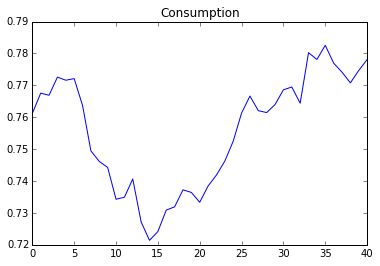

In [21]:
sim = simulate( dr, n_exp=1 )
pyplot.plot(sim['c'])
pyplot.title('Consumption')

# Change parameters at runtime

In [22]:
model.set_calibration({'beta':0.9})
drr = solve_decision_rule(model)

In [23]:
drr

{'Sigma': array([[ 0.0015]]),
 'ev': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.8       ,  0.95314608]),
 'g_a': array([[  8.00000000e-01,  -4.10752585e-18,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  1.00214668e+00,   9.53146078e-01,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  1.00214668e+00,  -2.18539224e-02,  -0.00000000e+00,
          -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
          -0.00000000e+00],
        [  1.60187858e-01,  -5.91656944e-03,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  1.17522492e-01,   4.50018673e-02,  -0.00000000e+00,
          -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
          -0.00000000e+00],
        [  3.94967058e-02,  -2.93556943e-03,  -0.00000000e+00,
          -0.00